In [14]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Import MNIST Dataset
from tensorflow.keras.datasets import mnist

from customnet import CustomNet

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg') # Non-interactive

import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import numpy as np
from imutils import paths, resize
import cv2
import os

plt.style.use('ggplot')

## Network architecture

In [5]:
dataset_classes = 10
datapoint_depth = 1
datapoint_dims = 28

# ((CONV => ReLU => BN) * 2 => POOL => DO) * 2 => ReLU => BN => DO
net = CustomNet()
model = net.build(
    datapoint_dims,
    datapoint_dims,
    num_classes=dataset_classes,
    depth=datapoint_depth
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)       

## Loading, processing and splitting the dataset

In [6]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [11]:
def preprocess(datapoint):
    ''' Preprocess an image (resize, extract patches...) '''
    if datapoint is not None:
        # Extract a random crop from the image
        datapoint = extract_patches_2d(
            datapoint,
            (datapoint_dims, datapoint_dims),
            max_patches=1
        )[0]
        # Transform image to array
        datapoint = img_to_array(datapoint, data_format=None)

        return datapoint

# Normalize [0, 1]
trainX = np.array(
    [preprocess(datapoint) for datapoint in trainX]
).astype('float') / 255.0

testX = np.array(
    [preprocess(datapoint) for datapoint in testX]
).astype('float') / 255.0

## Labels one-hot encoding

In [19]:
trainY = to_categorical(
    trainY,
    num_classes=dataset_classes
)

testY = to_categorical(
    testY,
    num_classes=dataset_classes
)

## Data Augmentation

In [20]:
daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

## Train the network

In [17]:
num_epochs = 20

### Learning rate scheduler : polynomial decay

$$\alpha = \alpha_{0} * (1 - e / e_{\max})^{^{p}}$$

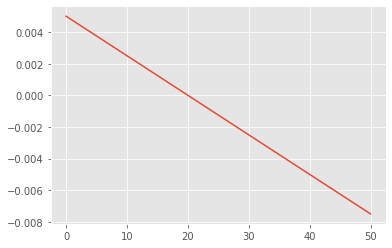

In [34]:
init_lr = 5e-3

def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 1.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

x = np.linspace(0, 50)
fx = [(init_lr * (1 - (x[i] / float(num_epochs))) ** 1.0) for i in range(len(x))]

%matplotlib inline
plt.plot(x, fx)
plt.show()

In [23]:
# Save best weights based on validation loss
checkpointHandler = ModelCheckpoint(
    'best_c10_weights.hdf5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    LearningRateScheduler(polynomial_decay),
    checkpointHandler
]

In [24]:
adam_opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

print('# Compiling the model...')
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

print('# Training the network...')
h = model.fit_generator(
    daug.flow(trainX, trainY, batch_size=256),
    validation_data=(testX, testY),
    epochs=num_epochs,
    steps_per_epoch=len(trainX) // 256,
    callbacks=callbacks,
    verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/20
233/234 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9338
Epoch 00001: val_loss improved from inf to 9.72245, saving model to best_c10_weights.hdf5
234/234 [==============================] - 19s 81ms/step - loss: 0.2178 - acc: 0.9339 - val_loss: 9.7224 - val_acc: 0.1229
Epoch 2/20
233/234 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9759
Epoch 00002: val_loss improved from 9.72245 to 0.88482, saving model to best_c10_weights.hdf5
234/234 [==============================] - 16s 70ms/step - loss: 0.0790 - acc: 0.9759 - val_loss: 0.8848 - val_acc: 0.8168
Epoch 3/20
233/234 [============================>.] - ETA: 0s - loss: 0.0664 - acc: 0.9792- ETA: 1s - 
Epoch 00003: val_loss improved from 0.88482 to 0.05119, saving model to best_c10_weights.hdf5
234/234 [==============================] - 17s 71ms/step - loss: 0.0663 - acc: 0.9792 - val_loss: 0.0512 - val_acc: 0.9817
Epoch 4/20
233/23

## Evalute the network

In [25]:
label_names = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]

print('# Trained the network! Evaluating...')
preds = model.predict(testX, batch_size=256)
print(classification_report(testY.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

# Trained the network! Evaluating...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



## Plot curves

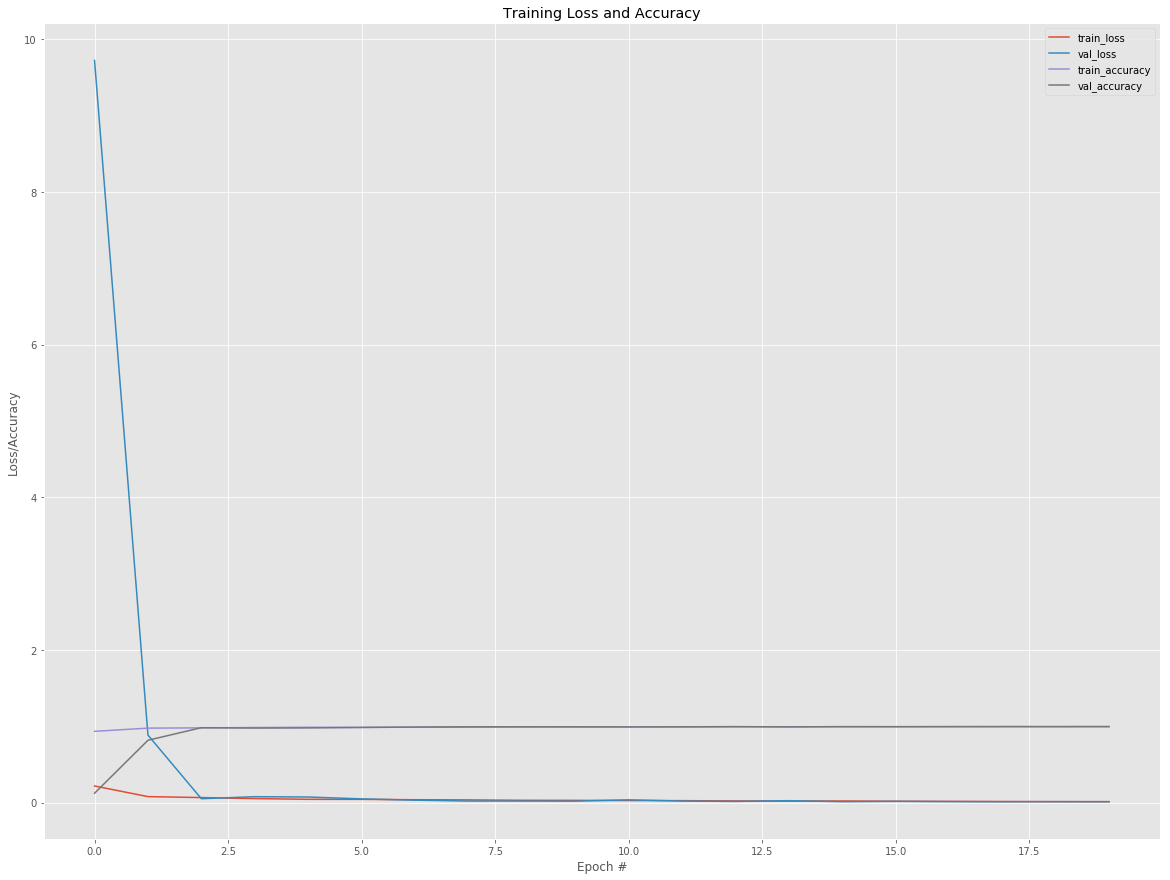

In [28]:
%matplotlib inline
plt.figure(figsize=(20, 15))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()